# Profiling missing data in Python

Once your data is safely localized, one of the first and most important things that you have to do at the beginning of any data analytics project is taking "a lay of the land" with your data. Data is fundamentally messy: full of oddities and noise and incomplete entries.

Getting a handle on this weirdness is an essential first step to getting anything actually done with it.

Thus one of the core skills of data analytics is understanding how your missing data is codistributed. In this tutorial we will tackle just that.

## What is missing data?

Not all missing data is equal. At the heart of the matter is the need to distinguish between two types of missingness:

* **Unknown but existing data**: This is data that we know exists, but which, due to sparse or incomplete sampling, we do not actually know the value of. There is some value there, however, and it would be useful to try to apply some sort of missing data interpolation technique in order to discover it.

   For example, in 2013 *The New York Times* published [a survey of income mobility in the United States](http://www.nytimes.com/2013/07/22/business/in-climbing-income-ladder-location-matters.html). As happens often in datasets which drill this deep (to a county level), there were several counties for which the newspaper could not trace data. Yet it would be possible, and easy, if it was truly necessary to do so, to interpolate reasonable values for these counties based on data from the surrounding ones, for instance, or based on data from other counties with similar demographic profiles. This is, fundamentally speaking, data that *can* be filled by some means.

<!-- ![Map of the US by Income Mobility](location_matters.png "Map of the US by Income Mobility") -->
 
  
* **Data that doesn't exist**: data that does not exist at all, in any shape or form.

  For example, it would make no sense to ask what the average household income is of residents of an industrial park or other such location where no people actually live. It would not *really* make sense to use 0 as a [sentinal value](https://en.wikipedia.org/wiki/Sentinel_value) in this case, either, because the existance of such a number implies in the first place the existance of people for whom an average can be taken&mdash;otherwise in trying to compute an average you are making a [divide by zero error](https://en.wikipedia.org/wiki/Division_by_zero)! This is, fundamentally speaking, data that *cannot* be filled by any means.


This is an important distinction to keep in mind, and implementing it in some standard way significantly complicates the picture. It means that to ask the question "is this data entry filled?" one must actually consider three possible answers: "Yes", "No, but it can be", and "No, and it cannot be". There seem to be two dominant paradigms for handling this distinction:

* **Bitpatterns**: Embed sentinal values into the array itself. For instance for integer data one might take `0` or `-9999` to signal unknown but existant data. This requires no overhead but can be confusing and oftentimes robs you of values that you might otherwise want to use (like `0` or `-9999`).


* **Masks**: Use a seperate boolean array to "mask" the data whenever missing data needs to be represented. This requires making a second array and knowing when to apply it to the dataset, but is more robust.

[Numpy](http://www.numpy.org/) is the linear algebra and vectorized mathematical operation library which underpins the Python scientific programming stack, and its methodologies inform how everything else works. Numpy has masks: these are provided via the `numpy.ma` module. But it has no native bitpatterns! There is still no performant native bitpattern `NA` type exists whatsoever.

The lack of a native `NA` type, as is the case in, say, R, is a **huge** problem for libraries, like [Pandas](http://pandas.pydata.org/), that are meant to be able to efficiently handle large datasets.

Indeed, **Pandas does not use the `numpy.ma` mask**. Masks are simply not performant above for the purposes of a library that is expected to be able to handle literally millions of entries entirely in-memory, as `pandas` does. Pandas instead defines and uses its own null value sentinels, particularly `NaN` (`np.nan`) for null numbers and `NaT` (a psuedo-native handled under-the-hood); and then allows you to apply your own `isnull()` mask to your dataset (more on that shortly). 

<span style="color:gray">
To read more on the conscientious backstory of missing data representation in `numpy` see the [NA-overview summary](http://www.numpy.org/NA-overview.html). To learn more about masked arrays see [its documentation](http://docs.scipy.org/doc/numpy/reference/maskedarray.html). For more on `pandas` missing data representation see the [`pandas` missing data documentation](http://pandas.pydata.org/pandas-docs/stable/missing_data.html).
</span>

With these technical notes in mind, let's now take a look at what tools and patterns `pandas` provides for missing data analysis.

## Some basic `pandas` munging

**Interpolation** and **dropping data** are the two ways of handling missing data, but in order to know how this ought to be done you need to have an understanding how your missing data is distributed. `pandas` provides a few expressions for doing so, but in my opinion is nowhere near as good at that task as it is at the former two.

Still, there are a few things we can do.

In [1]:
%matplotlib inline

import requests
import os
import pandas as pd

def download_file(url, filename):
    """
    Helper method handling downloading large files from `url` to `filename`. Returns a pointer to `filename`.
    """
    r = requests.get(url, stream=True)
    with open(filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024): 
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
    return filename


if not os.path.isfile("NYPD Motor Vehicle Collisions.csv"):
    dat = download_file("https://data.cityofnewyork.us/api/views/h9gi-nx95/rows.csv?accessType=DOWNLOAD",
                        "NYPD Motor Vehicle Collisions.csv")
data = pd.read_csv("NYPD Motor Vehicle Collisions.csv", index_col=23)

For the purposes of this tutorial I am using the NYC Open Data Portal's [Motor Vehicle Collision Dataset](https://data.cityofnewyork.us/api/views/h9gi-nx95/). This is a record of every motor vehicle incident report filed by the New York City Police Department in a certain period of time (approximately four years, as of writing).

Here are the dimensions:

In [2]:
data.shape

(769054, 28)

So 28 columns and the better part of a million rows. Let's grab an example entry:

In [3]:
data.sample(1)

,DATE,TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
UNIQUE KEY,,,,,,,,,,,,,,,,,,,,,
3336754,11/16/2015,17:40,NaN,NaN,40.864866,-73.888783,"(40.8648655, -73.8887833)",DECATUR AVENUE,EAST 197 STREET,NaN,...,Driver Inattention/Distraction,Traffic Control Disregarded,NaN,NaN,NaN,PASSENGER VEHICLE,SPORT UTILITY / STATION WAGON,NaN,NaN,NaN


Already you should be able to guess that `NaN` values are going to be predominant in certain cases. How many accidents have at least one vehicle? Well, it's a *motor vehicle* incident report, so presumably all of them (or will they!?!). The vehicle type codes that come afterwards should, logically, be rarer: a five-car accident ought to be far, far, far rarer than a single-car one.

But how much rarer, exactly?

For this we chain three different methods:

* The `isnull()` and `notnull()` methods type-cast to a `True` or `False` boolean mask which returns whether or not the underlying data is filled in or not (respectively).
* The `any()` expression can be used to check if *any* of the columns in a `pandas DataFrame` are filled
* The `all()` expression checks if *all* of them are filled.

Combining these methods gives us a laconic way of checking whether or not an entry is mandatory:

In [4]:
data.notnull().all()

DATE                              True
TIME                              True
BOROUGH                          False
ZIP CODE                         False
LATITUDE                         False
LONGITUDE                        False
LOCATION                         False
ON STREET NAME                   False
CROSS STREET NAME                False
OFF STREET NAME                  False
NUMBER OF PERSONS INJURED         True
NUMBER OF PERSONS KILLED          True
NUMBER OF PEDESTRIANS INJURED     True
NUMBER OF PEDESTRIANS KILLED      True
NUMBER OF CYCLIST INJURED         True
NUMBER OF CYCLIST KILLED          True
NUMBER OF MOTORIST INJURED        True
NUMBER OF MOTORIST KILLED         True
CONTRIBUTING FACTOR VEHICLE 1    False
CONTRIBUTING FACTOR VEHICLE 2    False
CONTRIBUTING FACTOR VEHICLE 3    False
CONTRIBUTING FACTOR VEHICLE 4    False
CONTRIBUTING FACTOR VEHICLE 5    False
VEHICLE TYPE CODE 1              False
VEHICLE TYPE CODE 2              False
VEHICLE TYPE CODE 3      

Aha! So `DATE`, `TIME`, and the `NUMBER` stuff is all completely recorded, but the rest is not. We can count the number of empties with `sum()`:

In [5]:
data.isnull().sum()

DATE                                  0
TIME                                  0
BOROUGH                          184301
ZIP CODE                         184368
LATITUDE                         121187
LONGITUDE                        121187
LOCATION                         121187
ON STREET NAME                   113619
CROSS STREET NAME                113619
OFF STREET NAME                  745262
NUMBER OF PERSONS INJURED             0
NUMBER OF PERSONS KILLED              0
NUMBER OF PEDESTRIANS INJURED         0
NUMBER OF PEDESTRIANS KILLED          0
NUMBER OF CYCLIST INJURED             0
NUMBER OF CYCLIST KILLED              0
NUMBER OF MOTORIST INJURED            0
NUMBER OF MOTORIST KILLED             0
CONTRIBUTING FACTOR VEHICLE 1      1691
CONTRIBUTING FACTOR VEHICLE 2     92379
CONTRIBUTING FACTOR VEHICLE 3    719206
CONTRIBUTING FACTOR VEHICLE 4    758798
CONTRIBUTING FACTOR VEHICLE 5    766485
VEHICLE TYPE CODE 1                 949
VEHICLE TYPE CODE 2               80194


Amazingly, yes, defeating our expectations, there are almost a thousand records completely lacking a `VEHICLE CODE 1`!

With a little bit more work you can get a nullity ratio:

In [6]:
data.isnull().sum() / len(data)

DATE                             0.000000
TIME                             0.000000
BOROUGH                          0.239646
ZIP CODE                         0.239733
LATITUDE                         0.157579
LONGITUDE                        0.157579
LOCATION                         0.157579
ON STREET NAME                   0.147739
CROSS STREET NAME                0.147739
OFF STREET NAME                  0.969063
NUMBER OF PERSONS INJURED        0.000000
NUMBER OF PERSONS KILLED         0.000000
NUMBER OF PEDESTRIANS INJURED    0.000000
NUMBER OF PEDESTRIANS KILLED     0.000000
NUMBER OF CYCLIST INJURED        0.000000
NUMBER OF CYCLIST KILLED         0.000000
NUMBER OF MOTORIST INJURED       0.000000
NUMBER OF MOTORIST KILLED        0.000000
CONTRIBUTING FACTOR VEHICLE 1    0.002199
CONTRIBUTING FACTOR VEHICLE 2    0.120120
CONTRIBUTING FACTOR VEHICLE 3    0.935183
CONTRIBUTING FACTOR VEHICLE 4    0.986664
CONTRIBUTING FACTOR VEHICLE 5    0.996660
VEHICLE TYPE CODE 1              0

So unsurprisingly, ~99.7% of accidents do not involve a fifth vehicle. That means that in most cases that column for these records are, in our earlier lexicon, examples of **data that doesn't exist**. By contrasts, since these are motor vehicle collision reports, not pedestrian-and-inanimate-object-collision reports, that 0.2% of entries lacking a `CONTRIBUTING FACTOR VEHICLE 1` are definitely **unknown but existing data**.

There is no implicit way of handling this distinction: either a record has an entry or it does not, in a binary way. You will have to keep this fact in mind yourself while targeting variables for interpolation or interpretation&mdash;without a native `NA` type there is no way of embedding this distinction into the data itself.

# Using `pandas-profiling` to understand distribution

Pandas provides many ways of writing your own methodologies for taking apart or slicing your data in a particular way&mdash;the expressions above are merely a way to get you started. Your next stop ought to be Pandas's extensive [visualization module](http://pandas.pydata.org/pandas-docs/stable/visualization.html), which attaches to and uses `matplotlib` to render information about any `DataFrame` that you can dream about.

However, when you are working on a project you do not want to handwrite those sorts of queries: doing so may be useful at the final, presentational step of your project, but right now you want a visualization of your data's distribution that *just works* as-is, without modification.

What you need is `pandas-profiling`.

Behold!

In [7]:
import pandas_profiling

In [8]:
pandas_profiling.ProfileReport(data.sample(10000))

Number of variables,29
Number of observations,10000
Total Missing (%),28.4%
Total size in memory,2.3 MiB
Average record size in memory,240.0 B
Numeric,10
Categorical,17
Date,0
Text (Unique),0
Rejected,2
Distinct count,6


This profile is an extensive summary of all the distribution and trouble spots of the dataset, providing, as one of its core facilities, an off-the-shelf by-column metric of data missingness.

It is not a complete replacement for the simple metrics we ran earlier, however, for a simple reason: it is very slow. The profiler will choke if handled more than a certain amount of entries and will take an unacceptable amount of time to return its take&mdash;this 10,000-record sample already takes a solid bead to run. You can't use it, therefore, for reliably spotting **extremely** rare missing values&mdash;for that you need to revert to the simpler earlier-demonstrated summation tools.

In this case the profiler does pick up everything, even the 0.4% of `VEHICLE TYPE CODE 5` entries which are not null. So a column really does have to be rarified to not show up at all; whether or not you can trust the fifty or so records that it did find and studied to be representative of the overall underlying distribution is another matter.

And if you pore through this extensive analysis you will spot something interesting: in the plurality of cases the contributing factor of the accident is specified as `Unspecified`. This sentinal value, embedded in the data itself, is yet another example of **unknown but existing data**. In this case we have so many records that, for the purposes of analysis, it'd be safe to drop these entries when necessary. In other cases this would be a bad idea and you will instead want to look into fixing&mdash;perhaps by replacing (via `pandas.replace()`) `Unspecified` with the `NaN` or `None` values which, as we previously discussed, represent empty data.

## Using `missingno` to understand codistribution

`pandas-profiling` provides an amazing tool for studying the nullity of columns in isolation, but it says nothing about something else that is very important: their codistribution.

An important issue in data interpolation is that it is almost never safe to simply drop missing entries. The problem is that data rarely goes missing in a truly random way. There is often instead some underlying pattern to be found in the data that you are missing, and understanding what that pattern is, exactly, is critical to data imputation. If you simply clumsily drop incomplete or insufficiently complete records from your analysis your resulting dataset will rarely be truly representative of the actual underlying data; nor will any of your statistical analyses pick up on the problem.

The only way to guard against this problem is to base your approach on a good understanding of what it is, exactly, that makes your data go missing. This requires both decent domain knowledge, often, and a tool for analyzing missing data codistribution.

`missingno` is that tool. I wrote it myself in order to better address the lack of data missingness visualization tools (specifically) in Python. `missingno` provides three heavily optimized visualizations for helping to understand how your missing data is distributed.

In [9]:
import missingno as msno

The first (and original) tool is the nullity matrix. Plug any `DataFrame` (or any sample out of a `DataFrame`) into the visualization and it will show you which values are and aren't filled.

This is a high data-density display which uses the simple but effective pattern-seeking ability of ones eye to visually cue in on patterns in the data.

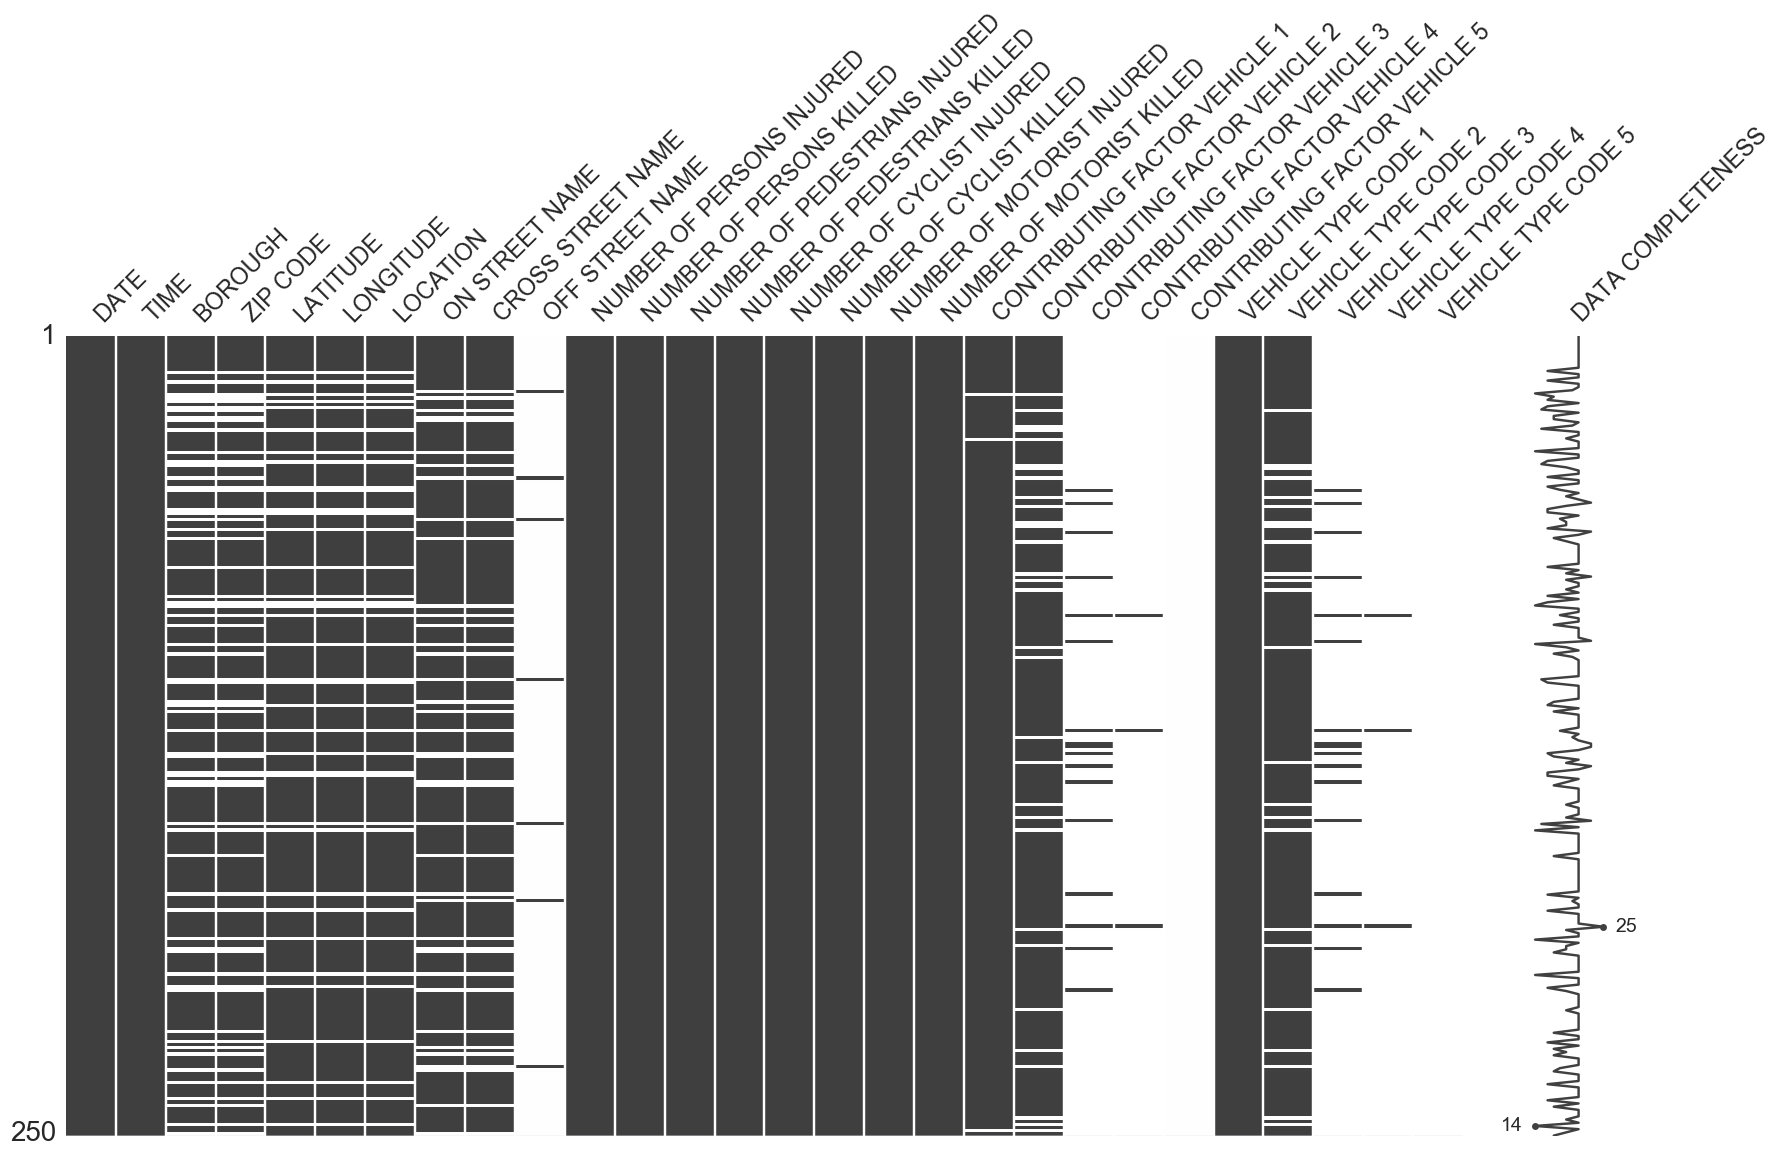

In [10]:
msno.matrix(data.sample(250))

You can immediately make quite a number of conclusions. That `CONTRIBUTING FACTOR  #` and `VEHICLE TYPE #` almost always appear simultaneously is not surprising, but is nice to confirm. Other facts are less obvious and more interesting. A police officer or data dictionary would be able to tell you that you get `ON STREET NAME` plus `CROSS STREET NAME` or `OFF STREET NAME` alone, but never both sets simultaneously. A police officer would *not* be able to tell you that `BOROUGH` and `ZIP CODE`, `LATITUDE` and `LONGITUDE` and `LOCATION`, and `ON STREET NAME` and `CROSS STREET NAME` are all pairwise distributed. These are particularities of the dataset that you are using that you have discover for yourself!

We can quantify this effect somewhat using the correlation heatmap.

<span style="color:gray">Note that this view is still experimental and in need of tweaking. I am not sure that covariance is the best way of indicating closeness of distribution for binary data. If you have a measure that you think would work better, let me know.</span>

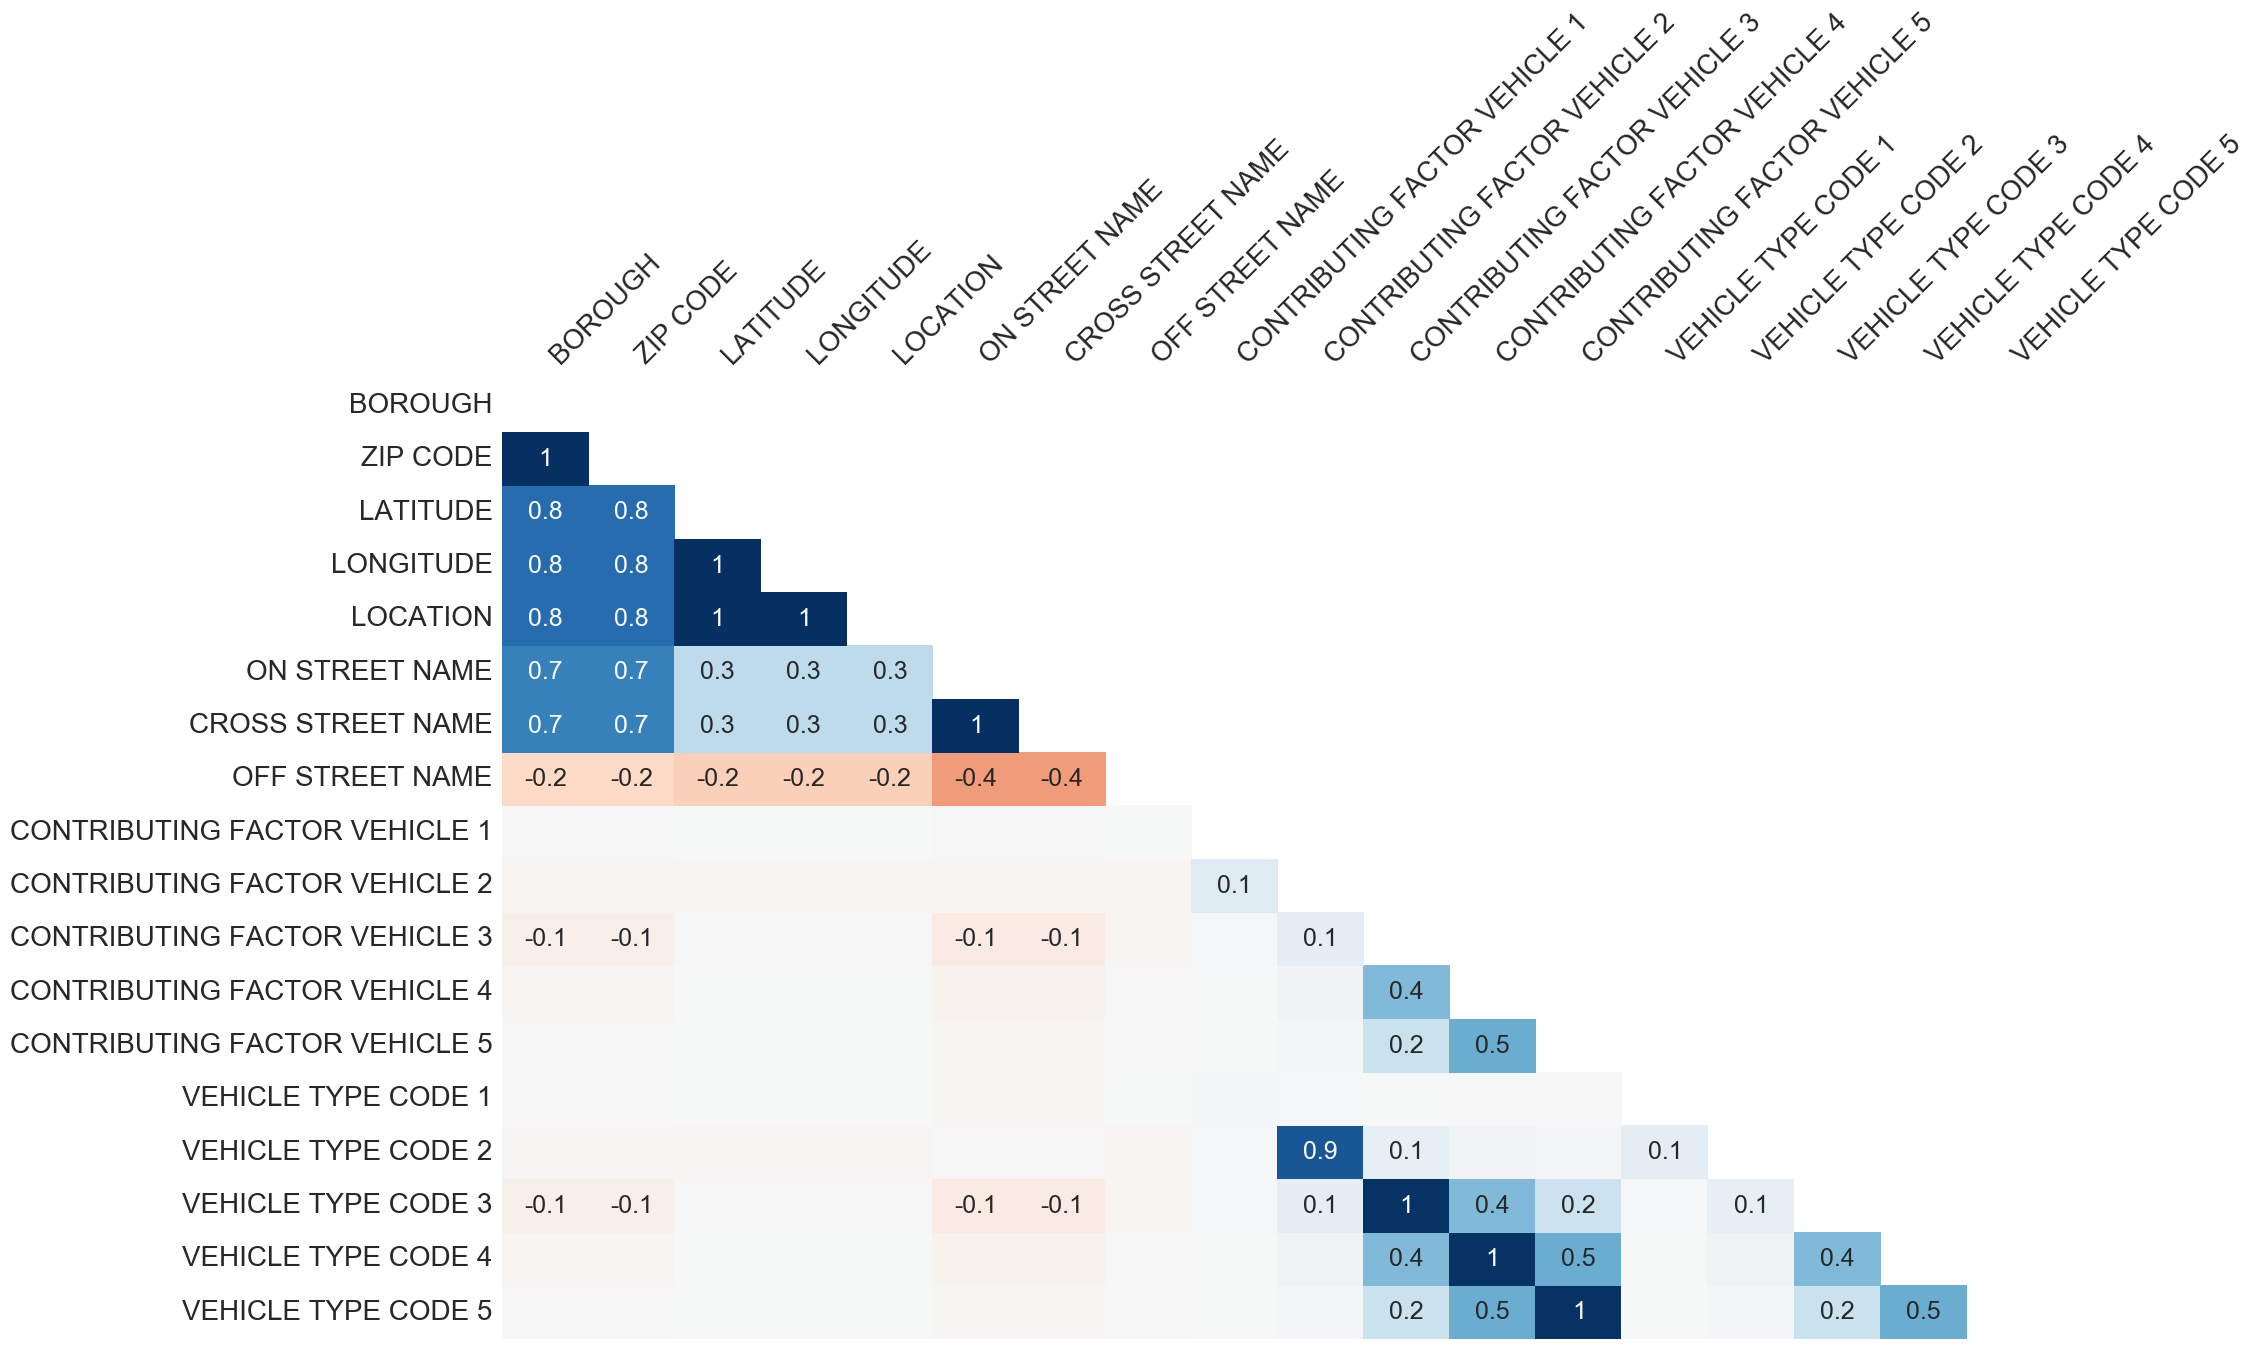

In [11]:
msno.heatmap(data)

Each entry in this heatmap is the covariance of the nullity of the two variables on the x axis and on the y. The pairwise nature of certain variables is again on display: `BOROUGH` and `ZIP CODE` have a covariance of 1, for instance, indicating that they compliment one another at all times. Unnumerated entries are those without statistically significant covariance (near `0`), indicative of truly random codistribution; these are omitted for visual clarity.

What's more, this view tells us something new: the presence of `OFF STREET NAME` has a strong negative effect on the completeness of the rest of the data, indicating that such reports tend to be more poorly filed or otherwise represented in the dataset, for some reason. `BOROUGH` and `ZIP CODE` tend to dovetail well with `LATITUDE`, `LONGITUDE`, and `LOCATION`: when one is missing usually so is the other, and vice versa. But not always&mdash;`0.9 != 1`!

Finally the most advanced view in the `missingno` package is the dendrogram. This view fits a hierarchical clusting algorithm to the nullity matrix for your dataset, arriving at a visual understanding of how the different variables tie in with one another.

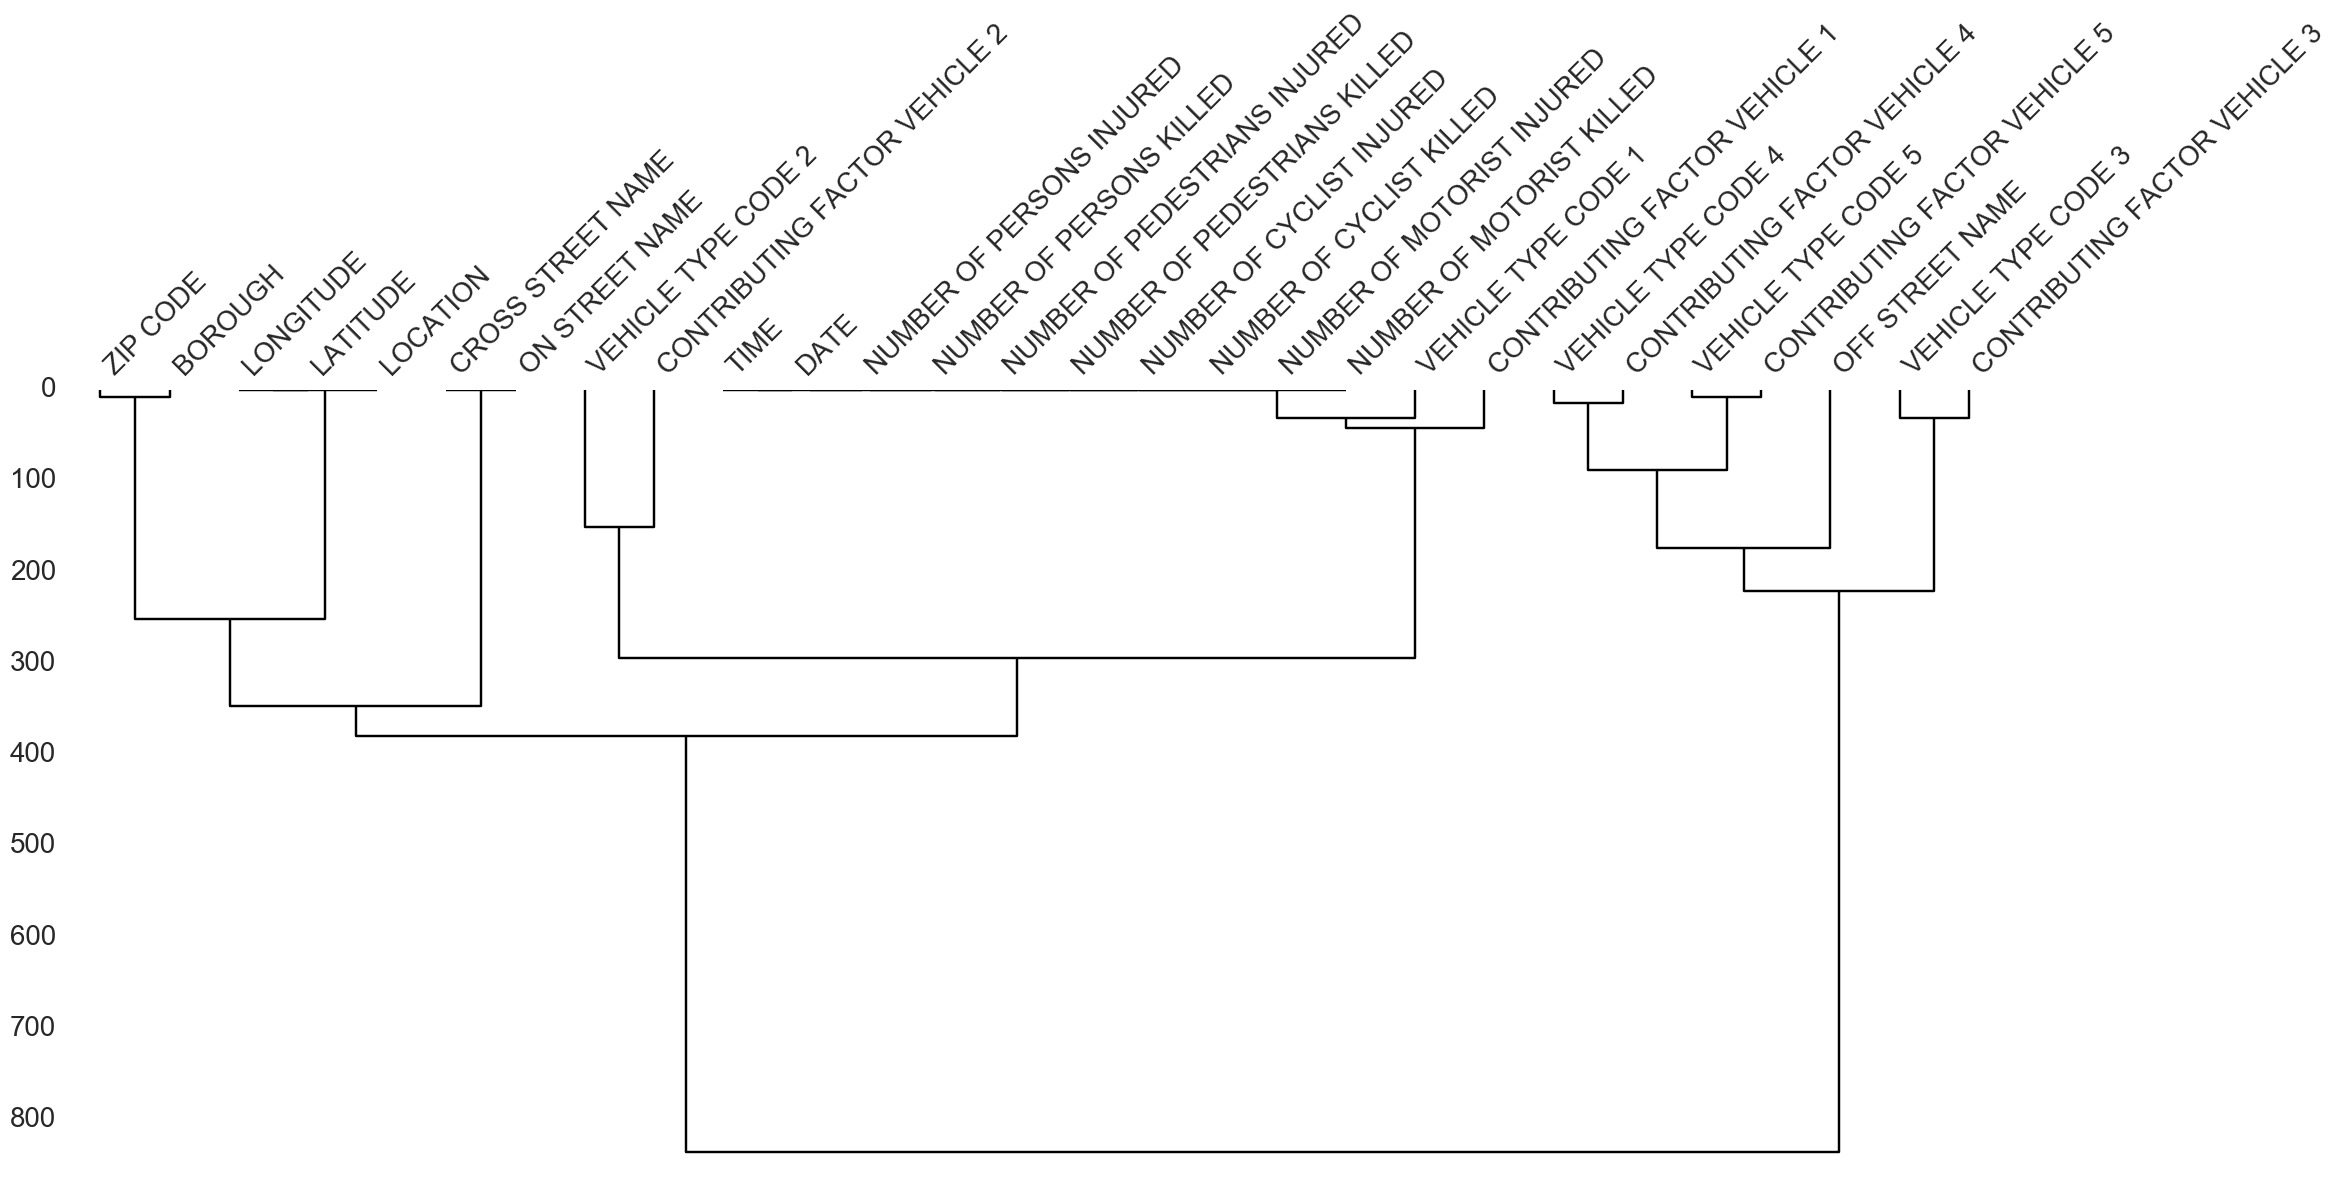

In [12]:
msno.dendrogram(data)

The y-axis of each split in this case is the distance in the variable cluster. The closer to 0 you are more often the variable cluster is always-True or always-False, right up to values at 0, which indicates variables which are in complete deterministic agreement with one another. It is in units of average distance: which is a count, in this binary case, of the average number of rows over which the columns disagree with one another.

What's nice about this view is that, unlike the other techniques, it is well and truly fully multivariate: the hierarchical clusting algorithm will pick up on sets of two, sets of five, sets of ten, and so on alike. And although also more difficult to interpret, a dendrogram is more accurate and more quanitifiable than reading closeness off of a nullity matrix and easier to read (physically) than a large heatmap. Just one example of an insight to be found here: notice that whilst the higher-numbered vehicle types and contributing factors completely determine one another, the first and second sets are more problematic.

## Working with big datasets

All of the demonstrations above are based on a (relatively) small dataset, column-wise. If your dataset has thousands of columns, what do you do?

First of all, `missigno.dendrogram()` will continue to work well. For `>50` columns it will flip to a left-right view in order to accomodate all of the variables and you'll have to do quite a bit of scrolling, but it will do it.

The basic `numpy` methods we saw earlier will of course also still work.

But throwing it all at once into a `ProfileReport` is clearly ludicriously impractical. You will have to filter it somehow first. `missingno` provides such a tool: the `nullity_filter()`. This method is both embedded in the `missingno` visualizations themselves and available as a standalone that you can import. It allows you to find the top or the bottom `n` (numerical) and/or `p` (ratio percentage) of columns in a dataset.

For instance, the following two methods equivalently map at the top twenty columns which are not always filled:

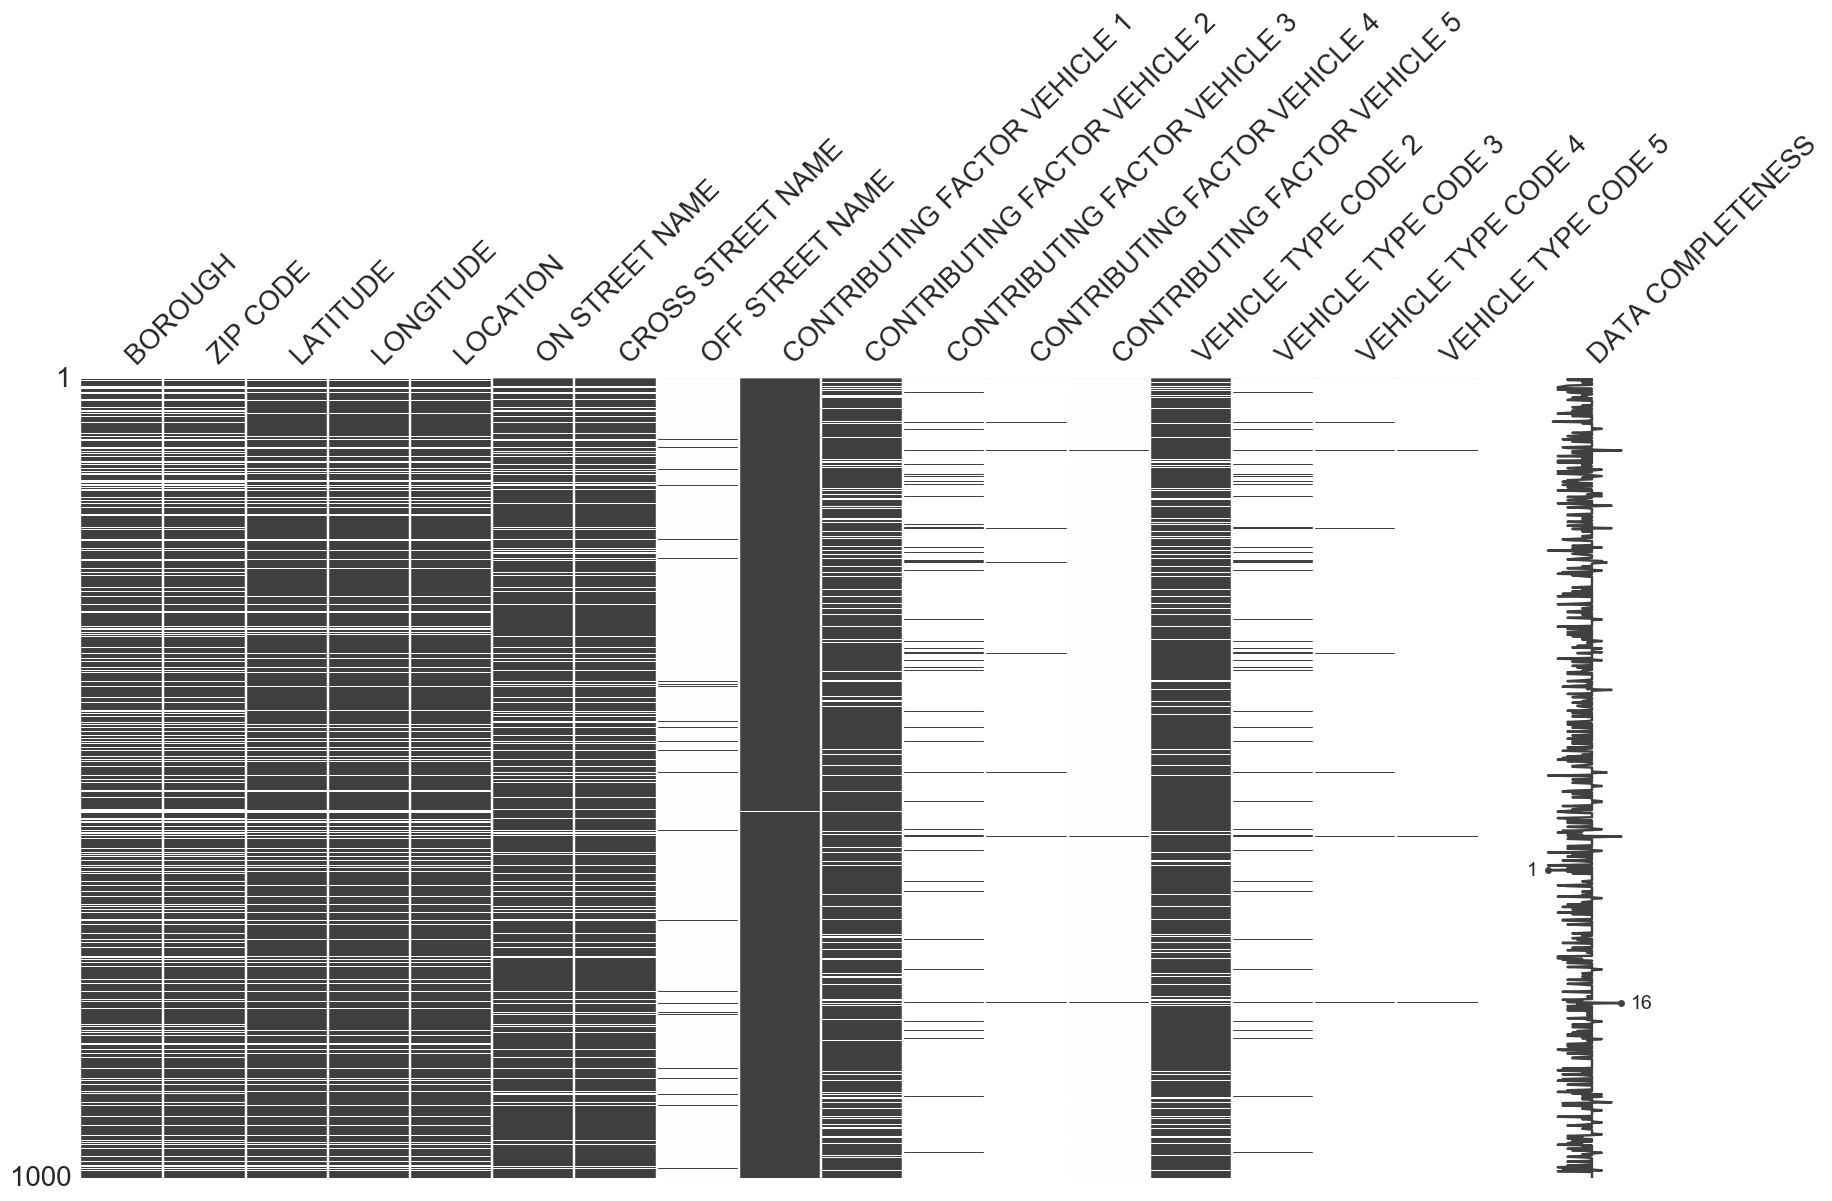

In [13]:
# filtered_data = msno.nullity_filter(data.sample(1000), filter='bottom', n=5, p=0.9)
# msno.matrix(filtered_data)
msno.matrix(data.sample(1000), filter='bottom', p=0.9999, n=20)

By the way, there's also a `nullity_sort()` that you can use to restructure your entire `DataFrame` by completeness:

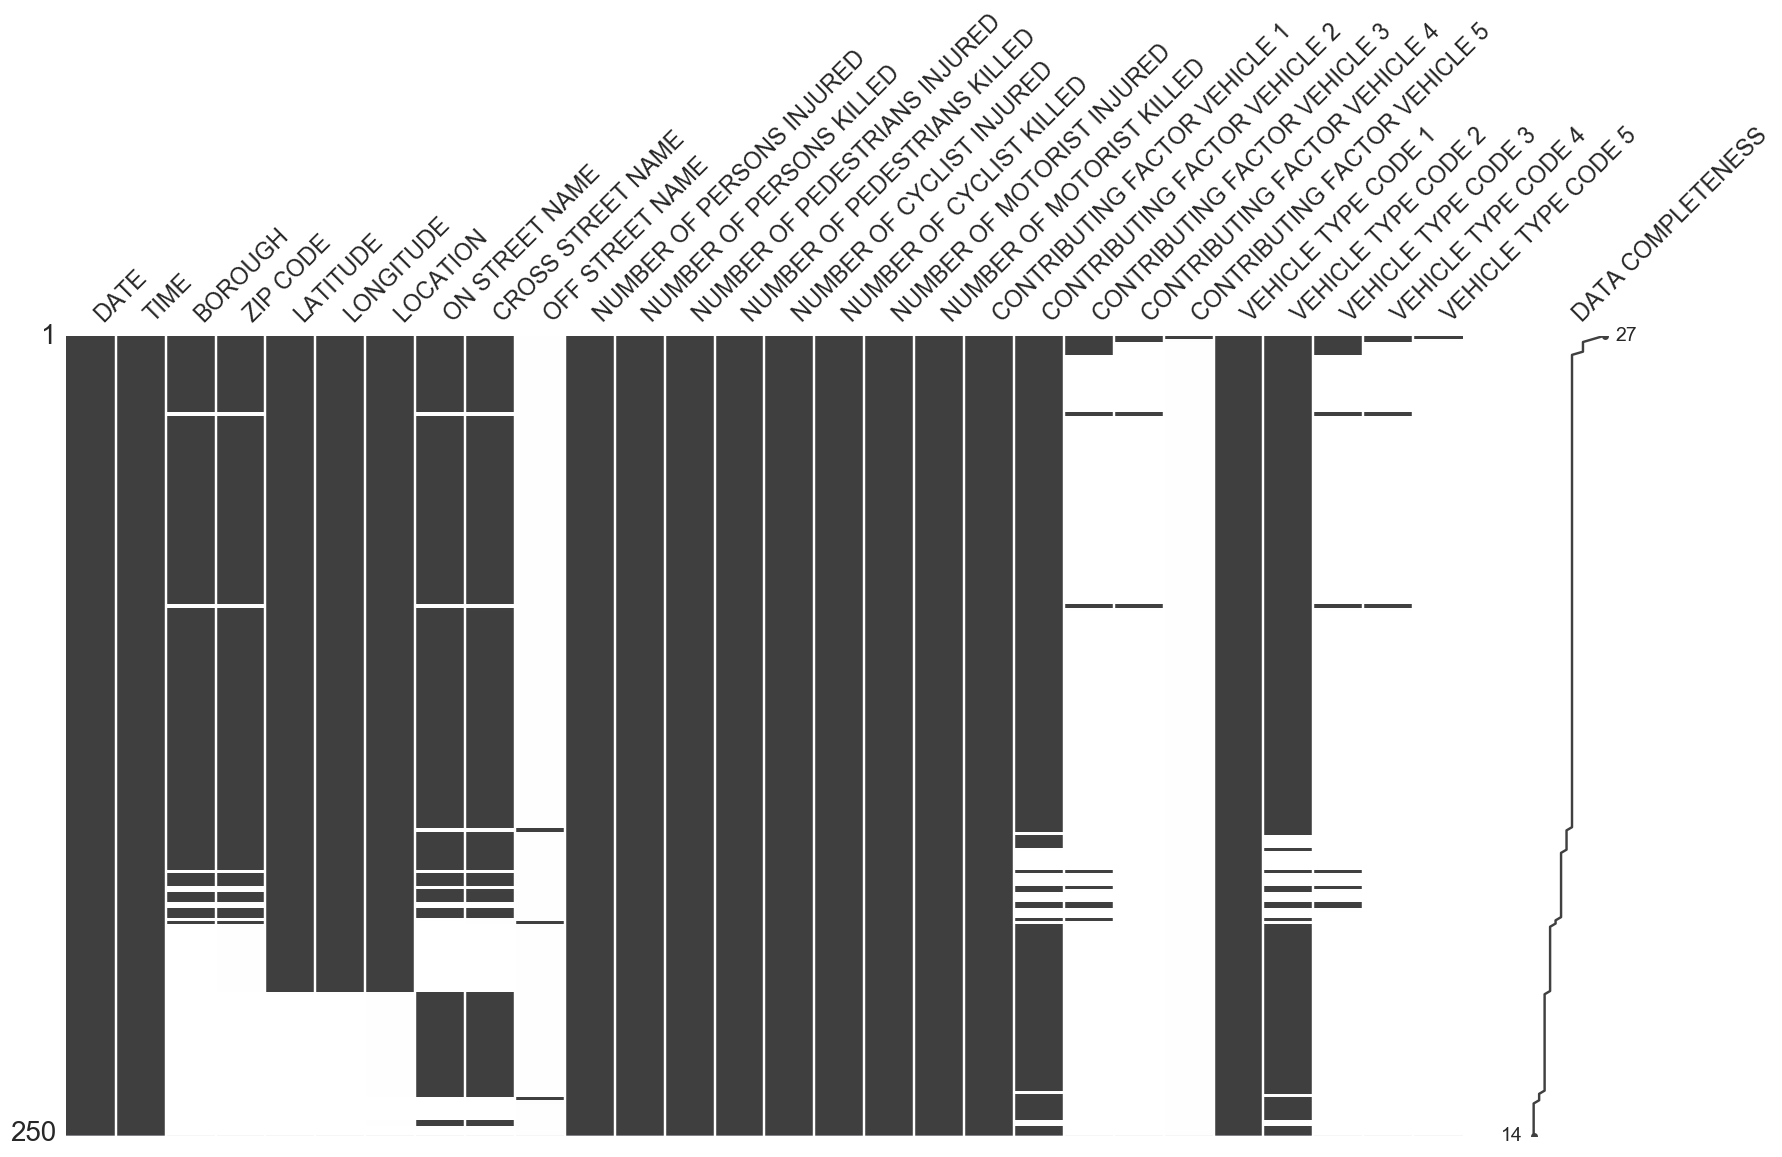

In [14]:
filtered_data = msno.nullity_sort(data.sample(250), sort='descending')
msno.matrix(filtered_data)

Once you have your data filtered how you want it&mdash;and have reduced it to a more managable number of columns of interest&mdash;*then* you can throw it into the `Pandas_Profiler()` (or whatever other visualization tool you happen to use) to see what you can find there.

## What comes next

Hopefully the methodologies, patterns, and libraries presented here give you a starting point from which you can start grappling with data missingness in your own work. With a solid understanding of how missing data is distributed and what it looks like, you should be ready to begin the next stop of the data cleaning process: inputing or dropping missing values.